In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

%matplotlib inline

# Step 1: Preprocessing

Preprocessing involving creation of Gaussian filter, convolution and sobel derivative. Most of the functions here have been taken from previous assignment. More information has been given in the form of comments.

In [2]:
def generate_gaussian_filter(k, sigma):
    o = k // 2
    a = np.linspace(-o, o, k)
    b = np.linspace(-o, o, k)
    
    y, x = np.meshgrid(a,b)
    
    pi_2sig = 2 * np.pi * sigma # 2*pi*sig
    x2_y2 = np.square(x) + np.square(y) # x^2 + y^2
    sig2 = np.square(sigma) # sig^2
    
    gaussian_filter = 1 / (pi_2sig)*np.exp(-(x2_y2)/(2*sig2))
    
    return gaussian_filter

In [3]:
def filtering(img, filter_ip):
    img_r, img_c = img.shape #get image dimensions
    filter_r, filter_c = filter_ip.shape #get filter dimensions
    
    out_img = np.zeros(img.shape)
    
    fill_h = int((filter_r - 1) / 2)
    fill_w = int((filter_c - 1) / 2)
    
    # Zero padding
    img_pad = np.zeros((img_r + (2 * fill_h), img_c + (2 * fill_w)))
    
    # Apply the pad on the original image
    img_pad[fill_h : img_pad.shape[0] - fill_h, fill_w : img_pad.shape[1] - fill_w] = img
            
    for r in range(img_r):
        for c in range(img_c):
            out_img[r,c] = np.sum(filter_ip * img_pad[r : r + filter_r, c : c + filter_c])
            
    return out_img

In [4]:
# Function for Ix, Iy, Ixx, Iyy and Ixy
def sobel_derivative(img, kernel):
    img_gradient = filtering(img, kernel)
    
    # calculating gradient of image
    gradient_2 = np.square(img_gradient)
    
    # Get magnitude of the gradient
    norm = np.sqrt(gradient_2)
    norm *= 255.0 / norm.max()
        
    return norm

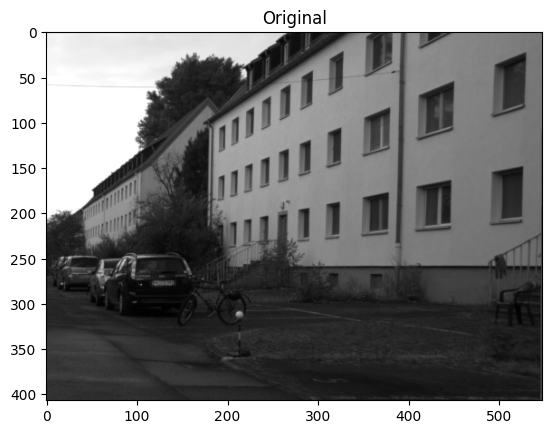

In [5]:
# Read original image
img_road = plt.imread("road.png")
road = cv2.cvtColor(img_road, cv2.COLOR_BGR2GRAY)

# Show original image
plt.title("Original")
plt.imshow(road, cmap='gray')
plt.savefig("output/original.png")

In [6]:
# create a 7x7 gaussian filter
# initialize sobel filter
gauss = generate_gaussian_filter(7, 0.5)
sobel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

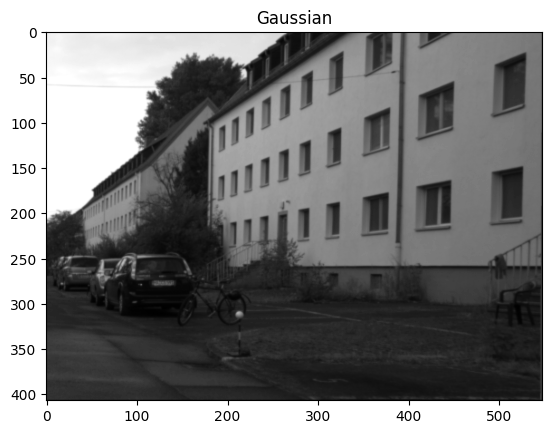

In [7]:
# apply the gaussian filter
road_gauss = filtering(road, gauss)

# Show Gaussian
plt.title("Gaussian")
plt.imshow(road_gauss, cmap='gray')
plt.savefig("output/gaussian.png")

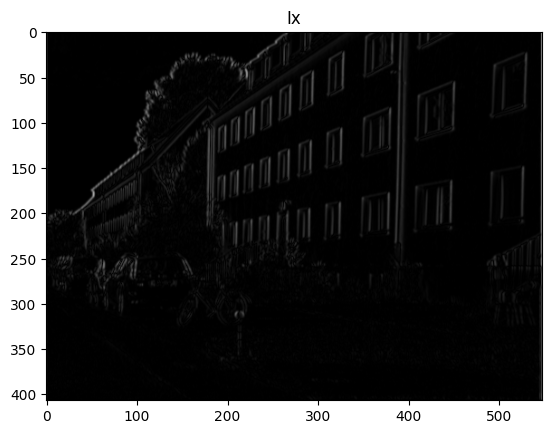

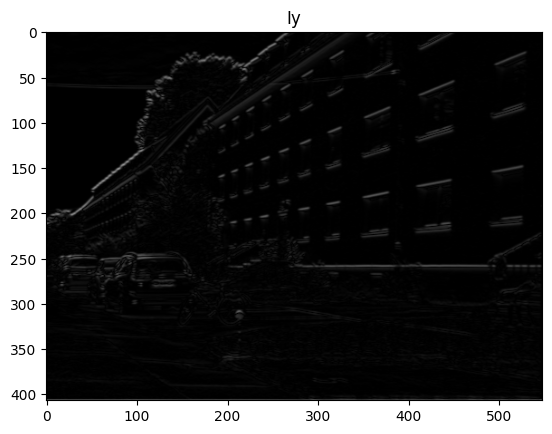

In [8]:
# Applying a sobel filter will result in getting the derivative
# get derivative in x and y
# for sobel_y filter, flip the filter and transpose
Ix = sobel_derivative(road_gauss, sobel)
Iy = sobel_derivative(road_gauss, np.flip(sobel.T, axis=0))

# Plot x and y first derivative
plt.title("Ix")
plt.imshow(Ix, cmap='gray', vmin=0, vmax=255)
plt.savefig("output/Ix.png")
plt.show()

plt.title("Iy")
plt.imshow(Iy, cmap='gray', vmin=0, vmax=255)
plt.savefig("output/Iy.png")
plt.show()

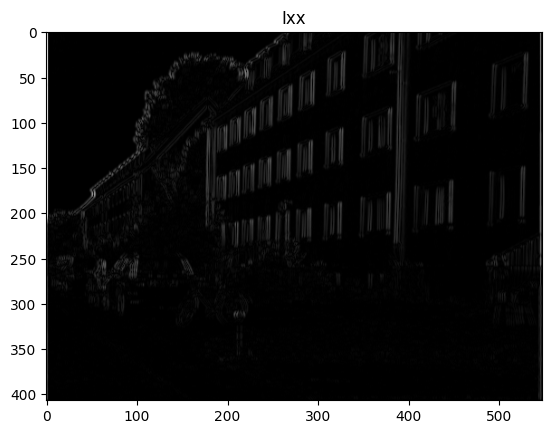

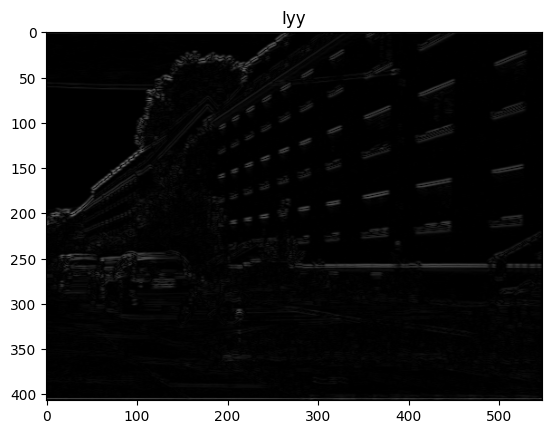

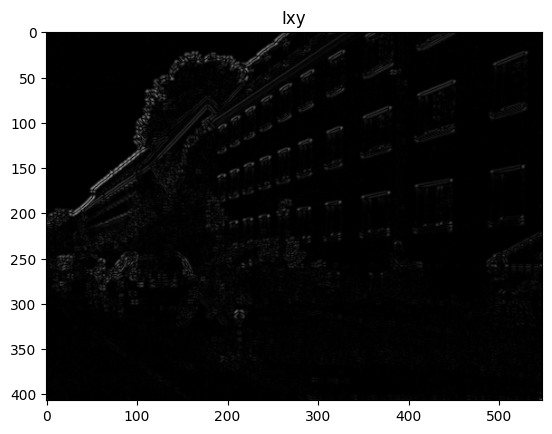

In [9]:
# double derivative will require applying sobel filter
# on the previous image Ix and Iy
Ixx = sobel_derivative(Ix, sobel)
Iyy = sobel_derivative(Iy, np.flip(sobel.T, axis=0))

# Plot x and y first derivative
plt.title("Ixx")
plt.imshow(Ixx, cmap='gray', vmin=0, vmax=255)
plt.savefig("output/Ixx.png")
plt.show()

plt.title("Iyy")
plt.imshow(Iyy, cmap='gray', vmin=0, vmax=255)
plt.savefig("output/Iyy.png")
plt.show()

# for Ixy, either use Ix and apply the Y filter
# or use Iy and apply X filter
Ixy = sobel_derivative(Ix, np.flip(sobel.T, axis=0))
plt.title("Ixy")
plt.imshow(Ixy, cmap='gray', vmin=0, vmax=255)
plt.savefig("output/Ixy.png")
plt.show()

In [10]:
# Hessian determinant
# multiply Ixx and Iyy and subtract from
# square of Ixy
hessian_determinant = (Ixx*Iyy) - (Ixy**2)

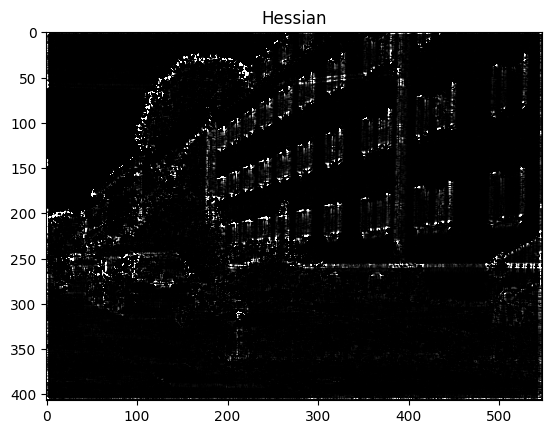

In [11]:
# View the image after Hessian
plt.title("Hessian")
plt.imshow(hessian_determinant, cmap='gray', vmin=0, vmax=255)
plt.savefig("output/hessian.png")
plt.show()

In [12]:
hessian_row, hessian_col = hessian_determinant.shape
hessian_nms = np.zeros(hessian_determinant.shape)

# define window size and offset
window = 3
offset = window // 2

threshold = 350

for x in range(offset, hessian_row - offset):
    for y in range(offset, hessian_col - offset):
        if hessian_determinant[x,y] > threshold:
            #hessian_nms[x,y] = hessian_determinant[x,y]
            hessian_nms[x,y] = 255 # if the value is above a threshold, it is white pixel

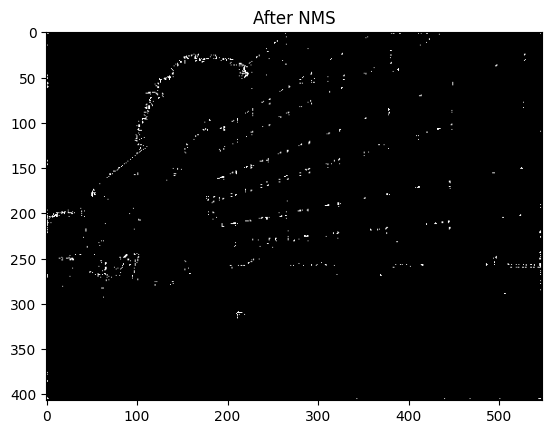

In [13]:
plt.title("After NMS")
plt.imshow(hessian_nms, cmap='gray', vmin=0, vmax=255)
plt.savefig("output/hessian_nms.png")

# Step 2: RANSAC

In [14]:
# references
# https://github.com/ahojnnes/numpy-snippets/blob/master/ransac.py
# https://medium.com/mlearning-ai/recursive-ransac-approach-to-find-all-straight-lines-in-an-image-b5c510a0224a
def run_ransac(img, ratio_given, max_dist, num_iters):
    # find coordinates where pixels have highest value
    data = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] == 255:
                data.append([i,j])
                
    # copied array
    data_temp = np.asarray(data)
    #print(data)
    #print(data_temp)
    
    arr = []
    final_lines = []
    
    # need 4 lines
    for _ in range(4):
        inliers = np.asarray(arr)
        inliers_temp = np.asarray(arr)
        ratio_final = 0
        slope = 0
        intercept = 0
        
        # loop over the number of iterations
        for _ in range(num_iters):
            # load data
            data_x, data_y = data_temp[:,0], data_temp[:,1]
            
            enum_counter = 0
            ratio_curr = 0
            
            
            # generate random points
            random_points = np.random.randint(0, len(data_temp), 2)
            # get starting points from those random points
            starting_points = np.asarray([data_temp[random_points[0]], data_temp[random_points[1]]])
            
            slope_m = (starting_points[1, 1] - starting_points[0, 1])/(starting_points[1, 0] - starting_points[0, 0])
            intercept_b = starting_points[1, 1] - (slope_m * starting_points[1, 0])
            
            # enumerate over the data
            # get distance of each points
            # compare with max_dist (threshold)
            # and check
            for e, (x, y) in enumerate(zip(data_x, data_y)):
                # for easy reading
                mx = slope_m * x                          # slope * x
                my = slope_m * y                          # slope * y
                mb = slope_m * intercept_b                # slope * intercept
                m_square = math.pow(slope_m, 2)           # slope^2
                
                x_pt = ((x + my) - mb) / (1 + m_square)
                y_pt = (mx + (m_square * y)) - (m_square * intercept_b) / (1 + m_square + intercept_b) 
                
                # euclidean distance
                distance = np.sqrt(math.pow((x_pt - x), 2) + math.pow((y_pt - y), 2))
                
                # compare with max_dist
                if distance < max_dist:
                    inliers_temp = np.append(inliers_temp, e)
                    enum_counter += 1
                    
            ratio_curr = len(inliers_temp) / (len(data_temp) * 2)
            
            # compare current ratio with given ratio and final ratio
            if ratio_curr > ratio_given and ratio_curr > ratio_final:
                ratio_final = ratio_curr
                ratio = ratio_curr
                inliers = inliers_temp
                slope = slope_m
                intercept = intercept_b
                
        final_lines.append([slope, intercept])
        data_temp = np.delete(data_temp, inliers.astype(np.uint), axis = 0)
        
    return np.asarray(final_lines)

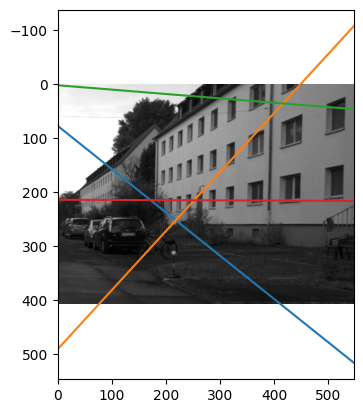

In [108]:
lines = run_ransac(img=hessian_nms, ratio_given=0, max_dist=0.97, num_iters=200)

m = lines[:4, 0]
b = lines[:4, 1]

plt.imshow(road, cmap = 'gray')

x = np.arange(0, hessian_nms.shape[1])
y1 = b[0] + (m[0] * x)
y2 = b[1] + (m[1] * x)
y3 = b[2] + (m[2] * x)
y4 = b[3] + (m[3] * x)

plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.plot(x,y4)
plt.savefig("output/ransac.png")

# Step 3: Hough Transform

In [17]:
# Hough space accumulator
# refernce from
# https://sbme-tutorials.github.io/2021/cv/notes/4_week4.html
def hough_space_accumulator(img):
    # get image dimensions
    img_y, img_x = img.shape
    # diagonal: pythagorean distance
    diag = int(np.ceil(np.sqrt(img_y**2 + img_x**2)))
    
    # initialize theta and rho arrays
    # value of theta rangese from (-90, 90) degrees
    theta_arr = np.deg2rad(np.arange(-90, 90))
    # rho defines the range of radius
    rho_arr = np.arange(-diag, diag + 1)

    # create hough accumulator array
    acc = np.zeros((len(rho_arr), len(theta_arr)))
    
    # find edge points
    y_idxs, x_idxs = np.nonzero(img)
    
    # loop through all the edge points and then
    # loop through all the theta values from theta_arr
    # to calculate rho values
    for idx in range(len(x_idxs)):
        x = x_idxs[idx]
        y = y_idxs[idx]

        for theta_idx in range(len(theta_arr)):
            rho = int((x * np.cos(theta_arr[theta_idx]) +
                    y * np.sin(theta_arr[theta_idx])) + diag)
            acc[rho, theta_idx] += 1

    return acc, theta_arr, rho_arr

In [18]:
# check hough space accumulator
acc, theta_arr, rho_arr = hough_space_accumulator(hessian_nms)

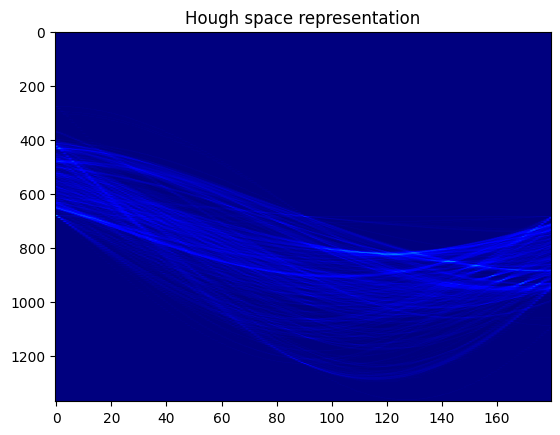

In [19]:
plt.title("Hough space representation")
plt.imshow(acc, cmap='jet', aspect='auto')
plt.savefig("output/hough space.png")

In [20]:
# check value for theta and rho
a = np.argmax(acc)
rho = int(rho_arr[int(a / acc.shape[1])])
theta = theta_arr[int(a % acc.shape[1])]

print("Theta: ", np.rad2deg(theta))
print("Rho: ", rho)

Theta:  -90.0
Rho:  -1


In [21]:
def hough_peaks(acc, num_peaks):
    idxs =  np.argpartition(acc.flatten(), -2)[-num_peaks:]
    return np.vstack(np.unravel_index(idxs, acc.shape)).T

In [22]:
peak_arr = hough_peaks(acc, 4)

In [23]:
peak_arr

array([[904, 158],
       [684,  90],
       [930, 169],
       [682,   0]], dtype=int64)

In [24]:
img_road1 = plt.imread("road1.png")
road1 = cv2.cvtColor(img_road, cv2.COLOR_BGR2GRAY)

for i in range(len(peak_arr)):
    rho = rho_arr[peak_arr[i][0]]
    theta = theta_arr[peak_arr[i][1]]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho

    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    
    # reference
    # https://stackoverflow.com/questions/18632276/how-to-draw-a-line-on-an-image-in-opencv
    out_img_hough = cv2.line(road1, (x1, y1), (x2, y2), (0, 255, 0), 2)

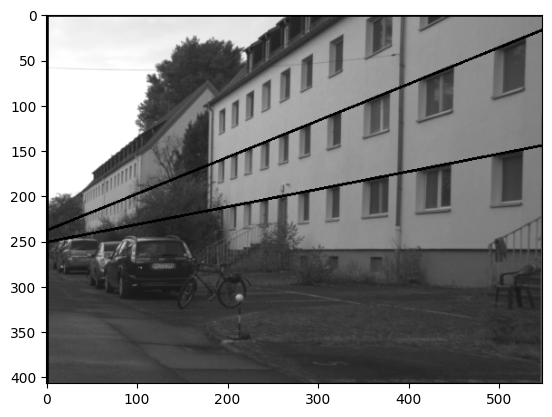

In [25]:
plt.imshow(out_img_hough, cmap='gray')

As we can see, not all 4 lines fall on the desired corners.